### Bo's Dataset and Toronto Centrelines
This file loads Bo's dataset/shapefile for cycling stress classification:<br>
(https://github.com/lin-bo/Toronto_LTS_network) <br>
It also loads in Toronto road shapefile taken from Toronto's Open Data Portal: <br>
(https://open.toronto.ca/dataset/neighbourhood-profiles/) <br>
(https://open.toronto.ca/dataset/neighbourhoods/) <br>

Work performed:
- load data (shapefile and Bo's LTS data targets).
- perform EDA to see if the road type could be used as a feature. Use dummy encoding.

#### Imports:

In [1]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
plt.style.use('dark_background')
#plt.style.use('ggplot')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

#### Import the raw data into a dataframe
Import both Bo's data and the centrelines with corresponding feature names

(59554, 12)


<AxesSubplot:>

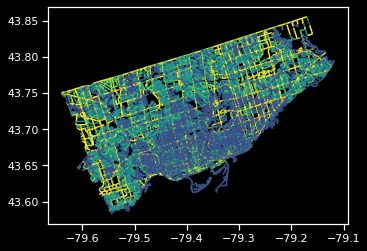

In [19]:
# import Bo's shapefile
file_path_keagan = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp'
file_path_saad = 'insert here for ease'
lts_gpd = gpd.read_file(file_path_keagan)
print(lts_gpd.shape)
lts_gpd.plot(column='LTS')

In [4]:
#Import the shapefile from open Toronto (see eda_toronto_centrelines)
geojsonpath = 'C:/Users/keaga/PycharmProjects/1498-ML-Project/data/raw_data/centreline_wgs84_geojson_v2/CENTRELINE_WGS84.geojson'
path2 = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/centreline_wgs84_geojson_v2/CENTRELINE_WGS84.geojson'
centrelines_gpd = gpd.read_file(path2)

centrelines_gpd.head()

,CENTRELINE_ID,LINEAR_NAME_ID,LINEAR_NAME_FULL,LINEAR_NAME_FULL_LEGAL,ADDRESS_L,ADDRESS_R,PARITY_L,PARITY_R,LO_NUM_L,HI_NUM_L,...,ONEWAY_DIR_CODE,ONEWAY_DIR_CODE_DESC,FEATURE_CODE,FEATURE_CODE_DESC,JURISDICTION,CENTRELINE_STATUS,OBJECTID,MI_PRINX,Shape__Length,geometry
0,14646677,4807,Antibes Dr,Antibes Drive,None,None,N,N,NaN,NaN,...,0,Not One-Way,201400,Collector,CITY OF TORONTO,None,419,419,3.922905,"LINESTRING (-79.45043 43.78194, -79.45039 43.7..."
1,14257954,11624,427 X S Gardiner X E Ramp,427 X S Gardiner X E Ramp,None,None,N,N,NaN,NaN,...,1,Follow-Digitization,201101,Expressway Ramp,PROVINCE,None,617,617,4.056786,"LINESTRING (-79.54894 43.61345, -79.54890 43.6..."
2,20079785,9580,Planning Boundary,Planning Boundary,None,None,N,N,NaN,NaN,...,0,Not One-Way,207001,Geostatistical line,CITY OF TORONTO,None,813,813,2.601053,"LINESTRING (-79.43889 43.64789, -79.43891 43.6..."
3,13969361,1892,Keane Ave,Keane Avenue,None,76-76,N,E,NaN,NaN,...,0,Not One-Way,201500,Local,CITY OF TORONTO,None,1460,1460,7.043388,"LINESTRING (-79.56017 43.64864, -79.56023 43.6..."
4,20054901,18818,Ww W Kennedy W Jade,Ww W Kennedy W Jade,None,None,N,N,NaN,NaN,...,0,Not One-Way,204002,Walkway,CITY OF TORONTO,None,1654,1654,4.935282,"LINESTRING (-79.29153 43.78104, -79.29157 43.7..."


#### Join centrelines to Bo's raod segments
WE need ot find the corresponding ID tag to join them, <br>
and we really only need to join the 'FEATURE_CODE' and 'FEATURE_CODE_DESC' <br>
Bo's README.md on github says you can join on 'GEO_ID' in lts_gpd

In [11]:
print(lts_gpd['GEO_ID'].min())
lts_gpd['GEO_ID'].head()

108


0    30079678
1    30079680
2    30079677
3    30082310
4    30008940
Name: GEO_ID, dtype: int64

In [12]:
centrelines_gpd['CENTRELINE_ID'].head()

0    14646677
1    14257954
2    20079785
3    13969361
4    20054901
Name: CENTRELINE_ID, dtype: int64

In [25]:
# Join the two dataframes by attribute join -> just use pandas merge
centrelines_metre = centrelines_gpd.to_crs("EPSG:26917")
lts_metre = lts_gpd.to_crs("EPSG:26917")

centre_merge = pd.merge(lts_metre, #left
                        centrelines_metre, #right
                        how='left',
                        left_on='GEO_ID',
                        right_on='CENTRELINE_ID',
                       )

print(centre_merge.shape)
centre_merge.head()

(59554, 53)


,OBJECTID_x,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,...,ONEWAY_DIR_CODE,ONEWAY_DIR_CODE_DESC,FEATURE_CODE,FEATURE_CODE_DESC,JURISDICTION,CENTRELINE_STATUS,OBJECTID_y,MI_PRINX,Shape__Length,geometry_y
0,1,30079678,19155,Waterfront Trl,30079676,30079656,0,457.224811,30079678,1,...,0.0,Not One-Way,204001.0,Trail,CITY OF TORONTO,None,189008.0,189008.0,632.040447,"LINESTRING (617480.231 4826902.150, 617480.138..."
1,2,30079680,19166,Marie Curtis Park Trl,30079676,30079679,0,35.226524,30079680,1,...,0.0,Not One-Way,204001.0,Trail,CITY OF TORONTO,None,189011.0,189011.0,48.578161,"LINESTRING (617480.231 4826902.150, 617476.262..."
2,3,30079677,19155,Waterfront Trl,30008708,30079676,0,37.170074,30079677,1,...,0.0,Not One-Way,204001.0,Trail,CITY OF TORONTO,None,189009.0,189009.0,51.366696,"LINESTRING (617498.782 4826933.578, 617490.916..."
3,4,30082310,10685,Island Rd,30008708,30082309,0,168.541328,30082310,1,...,0.0,Not One-Way,201600.0,Other,PRIVATE,None,191750.0,191750.0,232.814767,"LINESTRING (617498.782 4826933.578, 617516.356..."
4,5,30008940,19155,Waterfront Trl,30008711,30008708,0,84.289210,30008940,1,...,0.0,Not One-Way,204001.0,Trail,CITY OF TORONTO,None,56495.0,56495.0,116.430192,"LINESTRING (617552.626 4826998.138, 617541.915..."


In [27]:
# Convert back into a geodataframe
centre_merge = gpd.GeoDataFrame(centre_merge, geometry='geometry_x')

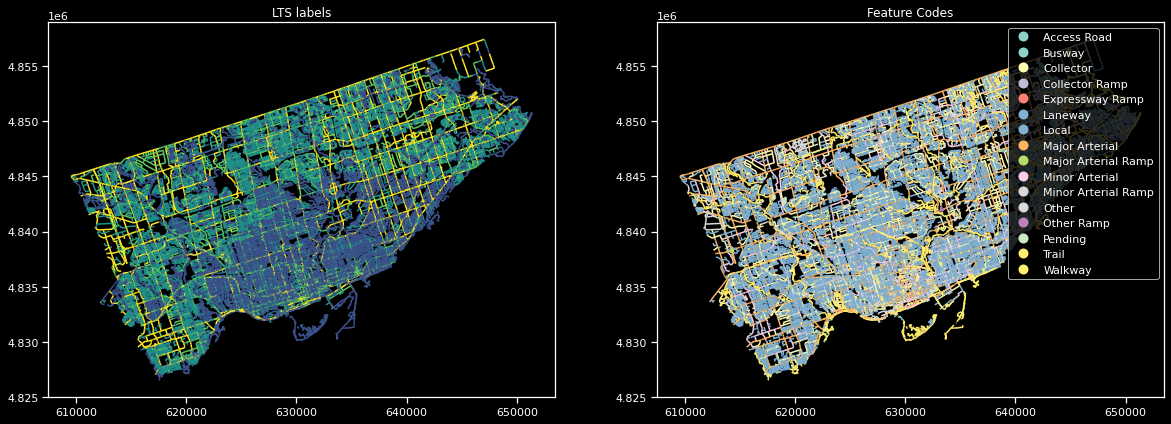

In [34]:
#Plot the LTS and feature descriptions to ensure the merge worked
fig, axs = plt.subplots(figsize=(20,12), ncols=2, nrows=1)

# Plotting
centre_merge.plot(ax=axs[0], column='LTS')
centre_merge.plot(ax=axs[1], column='FEATURE_CODE_DESC', legend=True, cmap='Set3')

# Attributes
axs[0].title.set_text('LTS labels')
axs[1].title.set_text('Feature Codes')

#### Look for statistical relationships, breakdown the feature codes in the dataframe.
It looks like from the graph that we can easily group some feature codes together with others <br>
##### NOTE!!! we actually probably don't want to use the feature code descriptions, as they contain info that is used in determining LTS (data leakage)
https://journals.sagepub.com/doi/pdf/10.3141/2587-06 see the original paper that describes how to determine LTS. We don't want to use any of this stuff, or at least it if we have the data it should be part of a PCA that determines which are the most important features in classification of LTS.

In [46]:
centre_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 59554 entries, 0 to 59553
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   OBJECTID_x              59554 non-null  int64   
 1   GEO_ID                  59554 non-null  int64   
 2   LFN_ID                  59554 non-null  int64   
 3   LF_NAME                 59554 non-null  object  
 4   FNODE                   59554 non-null  int64   
 5   TNODE                   59554 non-null  int64   
 6   ONE_WAY_DI              59554 non-null  int64   
 7   length_in_              59554 non-null  float64 
 8   GEO_ID_1                59554 non-null  int64   
 9   LTS                     59554 non-null  int64   
 10  Shape_Leng              59554 non-null  float64 
 11  geometry_x              59554 non-null  geometry
 12  CENTRELINE_ID           58627 non-null  float64 
 13  LINEAR_NAME_ID          58627 non-null  float64 
 14  LINEAR_NAME_FU

In [36]:
centre_merge['JURISDICTION'].unique()

array(['CITY OF TORONTO', 'PRIVATE', 'UNKNOWN', nan, 'FEDERAL',
       'PROVINCE'], dtype=object)

In [39]:
centre_merge[['LFN_ID', 'LF_NAME', 'LINEAR_NAME_ID', 'LINEAR_NAME_FULL', 'LINEAR_NAME']]

,LFN_ID,LF_NAME,LINEAR_NAME_ID,LINEAR_NAME_FULL,LINEAR_NAME
0,19155,Waterfront Trl,19155.0,Waterfront Trl,Waterfront
1,19166,Marie Curtis Park Trl,19166.0,Marie Curtis Park Trl,Marie Curtis Park
2,19155,Waterfront Trl,19155.0,Waterfront Trl,Waterfront
3,10685,Island Rd,10685.0,Island Rd,Island
4,19155,Waterfront Trl,19155.0,Waterfront Trl,Waterfront
...,...,...,...,...,...
59549,78,Crescent Town Rd,78.0,Crescent Town Rd,Crescent Town
59550,78,Crescent Town Rd,78.0,Crescent Town Rd,Crescent Town
59551,11101,Crescent Pl,11101.0,Crescent Pl,Crescent
59552,558,Dundas St W,558.0,Dundas St W,Dundas


<AxesSubplot:>

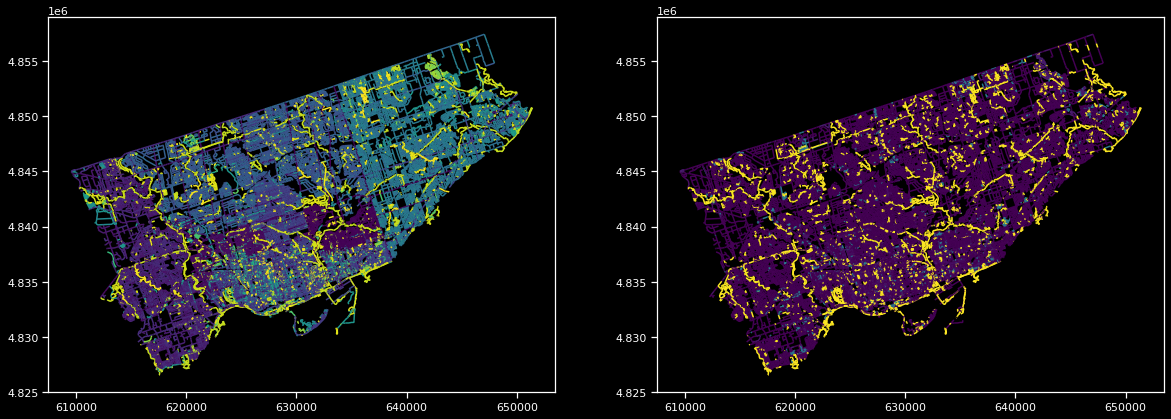

In [48]:
fig, axs = plt.subplots(figsize=(20,12), ncols=2, nrows=1)

# Plotting
centre_merge.plot(ax=axs[0], column='LFN_ID')
centre_merge.plot(ax=axs[1], column='FROM_INTERSECTION_ID')